In [12]:
import numpy as np
from discopy import optics
from discopy.optics import Box, Id, MZI

The basic generators are Mach Zender interferometers defined by (phase, angle):
optics.Box('MZI', PRO(2), PRO(2), data=[3.141592653589793, 3.141592653589793])

We can compose them in sequence or in parallel:


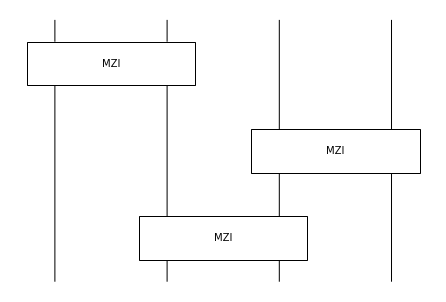


And evaluate the amplitude on given input/output occupation numbers:
input = [0, 1, 1, 0] 
output = [0, 1, 1, 0]
amplitude = (0.9999999999999999-2.449293598294706e-16j)
probability = 0.9999999999999998


In [13]:
print("The basic generators are Mach Zender interferometers defined by (phase, angle):")
mzi = MZI(np.pi, np.pi)
print(repr(mzi))

print("\nWe can compose them in sequence or in parallel:")
composition = mzi @ mzi >> Id(1) @ mzi @ Id(1)
composition.draw(draw_type_labels=False)

print("\nAnd evaluate the amplitude on given input/output occupation numbers:")
x = [0, 1, 1, 0]
y = [0, 1, 1, 0]
print("input = {} \noutput = {}".format(x, y))

amplitude = composition.amp(2, x, y)
print("amplitude = {}".format(amplitude))
print("probability = {}".format(np.absolute(amplitude)**2))

Given width and depth we can build a chip, i.e. an array of Mach Zender interferometers:


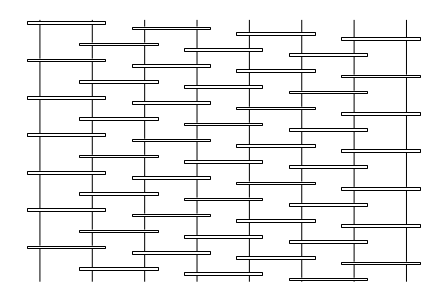

In [14]:
print("Given width and depth we can build a chip, i.e. an array of Mach Zender interferometers:")
# Given width and depth this code builds an array of Mach Zender interferometers

def build_chip(width, depth, params):   
    chip = Id(width)
    if width % 2 == 0:
        for i in range(depth):
            boxes = Id()
            if i % 2 == 0:
                for j in range(int(width / 2)):
                    boxes =  boxes @ MZI(*params[i, j])
            else:
                for j in range(int(width / 2) - 1):
                    boxes = boxes @ MZI(*params[i, j])
                boxes = Id(1) @ boxes @ Id(1)
            chip = chip >> boxes
    else: 
        for i in range(depth):
            boxes = Id()
            for j in range(int(width / 2)):
                    boxes =  boxes @ MZI(*params[i, j])  
            if i % 2 == 0:
                boxes = boxes @ Id(1)
            else:
                boxes = Id(1) @ boxes
            chip = chip >> boxes
    return chip

width = 8
depth = 14
def random_params(width, depth):
    return np.random.uniform(low=0.0, high=2*np.pi, size=(depth, int(width / 2), 2))
params0 = random_params(width, depth)
chip0 = build_chip(width, depth, params0)
chip0.draw(draw_type_labels=False, draw_box_labels=False)

Chips of the same width can be composed:


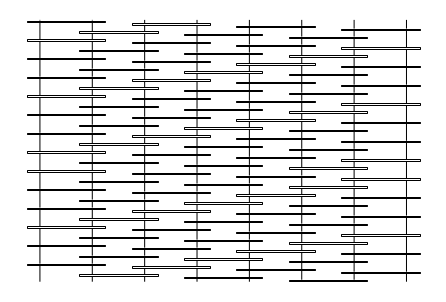

In [15]:
# Two chips can be composed in sequence with >>
params1 = random_params(width, depth)
chip1 = build_chip(width, depth, params1)
print("Chips of the same width can be composed:")
(chip0 >> chip1).draw(draw_type_labels=False, draw_box_labels=False)

In [16]:
print("Choose entities and relations:")

E = ["Alice", "Bob", "Claire", "Dave"]
print(E)
R = ["loves", "hates", "kills"]
print(R)
W = E + R

print("This defines a language of subject-verb-object sentences:")

triples = [(s, v, o) for s in E for v in R for o in E]
triples

Choose entities and relations:
['Alice', 'Bob', 'Claire', 'Dave']
['loves', 'hates', 'kills']
This defines a language of subject-verb-object sentences:


[('Alice', 'loves', 'Alice'),
 ('Alice', 'loves', 'Bob'),
 ('Alice', 'loves', 'Claire'),
 ('Alice', 'loves', 'Dave'),
 ('Alice', 'hates', 'Alice'),
 ('Alice', 'hates', 'Bob'),
 ('Alice', 'hates', 'Claire'),
 ('Alice', 'hates', 'Dave'),
 ('Alice', 'kills', 'Alice'),
 ('Alice', 'kills', 'Bob'),
 ('Alice', 'kills', 'Claire'),
 ('Alice', 'kills', 'Dave'),
 ('Bob', 'loves', 'Alice'),
 ('Bob', 'loves', 'Bob'),
 ('Bob', 'loves', 'Claire'),
 ('Bob', 'loves', 'Dave'),
 ('Bob', 'hates', 'Alice'),
 ('Bob', 'hates', 'Bob'),
 ('Bob', 'hates', 'Claire'),
 ('Bob', 'hates', 'Dave'),
 ('Bob', 'kills', 'Alice'),
 ('Bob', 'kills', 'Bob'),
 ('Bob', 'kills', 'Claire'),
 ('Bob', 'kills', 'Dave'),
 ('Claire', 'loves', 'Alice'),
 ('Claire', 'loves', 'Bob'),
 ('Claire', 'loves', 'Claire'),
 ('Claire', 'loves', 'Dave'),
 ('Claire', 'hates', 'Alice'),
 ('Claire', 'hates', 'Bob'),
 ('Claire', 'hates', 'Claire'),
 ('Claire', 'hates', 'Dave'),
 ('Claire', 'kills', 'Alice'),
 ('Claire', 'kills', 'Bob'),
 ('Claire', 

In [17]:
# Now we construct a mapping to photonic chips

width = 4
n_photons = 2
x = [0, 1, 1, 0] # input occupation numbers
y = x # output occupation numbers

print("Hardware hyperparameters:")
print(" width: {} \n number of photons: {} \n input occupations: {} \n output occupations: {}".format(width, n_photons, x, y))

Hardware hyperparameters:
 width: 4 
 number of photons: 2 
 input occupations: [0, 1, 1, 0] 
 output occupations: [0, 1, 1, 0]


In [18]:
# Given a depth for words and parameters, we have a mapping from words to photonic chips:
depth = 5 # depth for each word 
print("Linguistic hyperparameters:")
print(" number of entities: {} \n number of relations: {}\n depth for each word: {}".format(len(E), len(R), depth))

Linguistic hyperparameters:
 number of entities: 4 
 number of relations: 3
 depth for each word: 5


In [19]:
params = np.random.uniform(low=0.0, high=np.pi, size=(len(W), depth, int(width / 2), 2))
print("Initialised random parameters of shape: {}\n".format(np.shape(params)))

print("number of words: {} \ndepth for each word: {}\nmax number of MZIs per layer : {} \nnumber of params per MZI: {}\n\n".format(*np.shape(params)))
# getting Product 
def prod(val) : 
    res = 1 
    for ele in val: 
        res *= ele 
    return res 
print("Total number of parameters: {}".format(prod(np.shape(params))))

# The parameters define a mapping from words to chips.
functor = lambda depth, params: {W[i] : build_chip(width, depth, params[i]) for i in range(len(W))}
F = functor(depth, params)

Initialised random parameters of shape: (7, 5, 2, 2)

number of words: 7 
depth for each word: 5
max number of MZIs per layer : 2 
number of params per MZI: 2


Total number of parameters: 140


`Bob' is sent to the following chip:


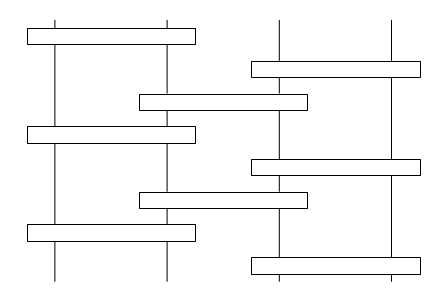

The triple `Alice loves Bob' is sent to the following chip:


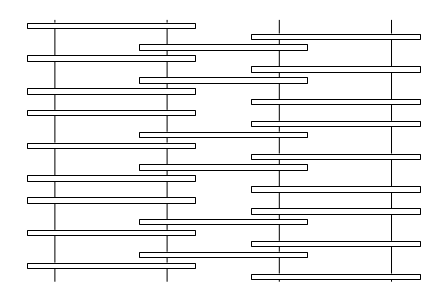

In [20]:
print("`Bob' is sent to the following chip:")
F["Bob"].draw(draw_type_labels=False, draw_box_labels=False)
print("The triple `Alice loves Bob' is sent to the following chip:")
(F["Alice"] >> F["loves"] >> F["Bob"]).draw(draw_type_labels=False, draw_box_labels=False)

In [21]:
# With the mapping F we can evaluate a triple:
evaluate = lambda F, triple: np.absolute((F[triple[0]] >> F[triple[1]] >> F[triple[2]]).amp(n_photons, x, y))**2

print("'Alice loves Bob' evaluates to the the score:")
evaluate(F, ("Alice", "loves", "Bob"))

'Alice loves Bob' evaluates to the the score:


0.0592934643820317

In [22]:
print("Get the scores for each triples:")
for i in range(len(triples)):
    print("{} : {}".format(evaluate(F, triples[i]), triples[i]))

Get the scores for each triples:
0.0024162779004011804 : ('Alice', 'loves', 'Alice')
0.0592934643820317 : ('Alice', 'loves', 'Bob')
0.014651133478094658 : ('Alice', 'loves', 'Claire')
0.008335701910225632 : ('Alice', 'loves', 'Dave')
0.28303593476845634 : ('Alice', 'hates', 'Alice')
0.04033947614750522 : ('Alice', 'hates', 'Bob')
0.18800345352912573 : ('Alice', 'hates', 'Claire')
0.04287204240992409 : ('Alice', 'hates', 'Dave')
0.12493087163733341 : ('Alice', 'kills', 'Alice')
0.05305184501742064 : ('Alice', 'kills', 'Bob')
0.0037920391693388044 : ('Alice', 'kills', 'Claire')
0.06850781153156178 : ('Alice', 'kills', 'Dave')
0.1161093060341547 : ('Bob', 'loves', 'Alice')
0.0116708393153169 : ('Bob', 'loves', 'Bob')
0.009164930977859384 : ('Bob', 'loves', 'Claire')
0.16124123027801168 : ('Bob', 'loves', 'Dave')
0.24527690583262737 : ('Bob', 'hates', 'Alice')
0.032781795611259296 : ('Bob', 'hates', 'Bob')
0.17805688000122935 : ('Bob', 'hates', 'Claire')
0.021155987332519662 : ('Bob', 'hat